In [10]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelBinarizer, OneHotEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
# from keras.applications.resnet import ResNet101, preprocess_input
from keras import Input
from keras.callbacks import EarlyStopping, ModelCheckpoint
from PIL import Image
from tensorflow.keras.optimizers import Adam, RMSprop
from shutil import rmtree
from itertools import cycle
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
import seaborn as sb
import tensorflow as tf
import matplotlib.cm as cm

# Project variables

In [11]:
m_name = "cnn2_4_classes"
p_dir = os.path.join("../img models", m_name)

In [12]:
def create_dir(dir_path: str):
    if not os.path.exists(dir_path):
        os.mkdir(dir_path)

In [13]:
def clear_dir(dir_path: str):
    for item in os.listdir(dir_path):
        fp = os.path.join(dir_path, item)
        if os.path.isfile(fp):
            os.remove(fp)
        if os.path.isdir(fp):
            rmtree(fp)

In [14]:
create_dir(p_dir)
clear_dir(p_dir)

# Read and transform scraped dataframes

In [15]:
fp = "../scraped data"

channels = pd.read_pickle(os.path.join(fp, "channels.pkl"))
videos = pd.read_pickle(os.path.join(fp, "videos.pkl"))

In [16]:
def transform_channels(df: pd.DataFrame) -> pd.DataFrame:
    # Date string into proper date
    df.published = pd.to_datetime(df.published)
    
    # Convert field type into int64
    fields = ["video_count", "view_count"]
    df.loc[:, fields] = df.loc[:, fields].astype("int64")
    
    # Convert field type into float64
    fields = ["subscriber_count"]
    df.loc[:, fields] = df.loc[:, fields].astype("float64")
    
    # Add of channel in months
    df["age_mth"] = (pd.to_datetime("today", utc=True).year - df.published.dt.year) * 12 \
        + (pd.to_datetime("today", utc=True).month - df.published.dt.month)
        
    # Drop unnecessary fields
    df.drop(columns=["custom_url", "country"] + [c for c in df.columns if c.startswith("thumbnail")], inplace=True)
    
    # Remove channels without subscriber_count
    df = df.loc[df.subscriber_count.notnull(), :]
    
    return df

In [17]:
def transform_videos(df: pd.DataFrame) -> pd.DataFrame:    
    # Date string into proper date
    df.published = pd.to_datetime(df.published)
    
    # Convert field type to bool
    fields = ["broadcast"]
    df.loc[:, fields] = df.loc[:, fields].astype("bool")
    
    # Convert field type into int64
    fields = ["category_id"]
    df.loc[:, fields] = df.loc[:, fields].astype("int64")
    
    # Convert field type into float64
    fields = ["comment_count", "dislike_count", "like_count", "view_count"]
    df.loc[:, fields] = df.loc[:, fields].astype("float64")
    
    df["published_mth"] = (pd.to_datetime("today", utc=True).year - df.published.dt.year) * 12 \
        + (pd.to_datetime("today", utc=True).month - df.published.dt.month)
    df["title_len"] = df.title.str.len()
    
    df.drop(columns=["favorite_count", "broadcast", "audio_language", "comment_count", "category_id"] \
            + [c for c in df.columns if c.startswith("thumbnail")], inplace=True)
    
    df = df.loc[df.like_count.notnull() & df.dislike_count.notnull() & df.view_count.notnull(), :]
    
    return df

In [18]:
channels_trans = transform_channels(channels)
videos_trans = transform_videos(videos)
combo = videos_trans.merge(channels_trans[["id", "view_count","published", "age_mth", "subscriber_count",
                                             "video_count"]], 
                           how="inner", left_on="channel_id", right_on="id", suffixes=["_video", "_channel"])
combo["ln_vc_norm"] = np.log(combo.view_count_video / combo.subscriber_count)

# Define categories

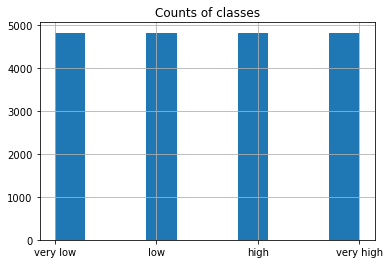

In [19]:
cat_lbl = ["very low", "low", "high", "very high"]
combo.loc[:, "qtl"] = pd.qcut(combo.ln_vc_norm, len(cat_lbl), labels=cat_lbl, precision=6)
combo.sort_values(by=["qtl"]).qtl.hist()
plt.title("Counts of classes")
plt.show()

# Split dataset

In [20]:
y = combo.qtl
x = combo.loc[:, [c for c in combo.columns if c != "qtl"]]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=4711)

x_train.to_pickle(os.path.join(p_dir, "x_train.pkl"))
y_train.to_pickle(os.path.join(p_dir, "y_train.pkl"))
x_val.to_pickle(os.path.join(p_dir,"x_val.pkl"))
y_val.to_pickle(os.path.join(p_dir, "y_val.pkl"))
x_test.to_pickle(os.path.join(p_dir,"x_test.pkl"))
y_test.to_pickle(os.path.join(p_dir, "y_test.pkl"))

print(x_train.shape[0], x_val.shape[0], x_test.shape[0])

11586 3862 3863


# Build the model

In [21]:
def create_model():
    
    model = Sequential()
    
    # Add layers
    model.add(Conv2D(32, (5, 5), padding="same", activation="relu", input_shape=(120, 90, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (7, 7), padding="same", activation="relu"))    
    model.add(Conv2D(64, (5, 5), padding="same", activation="relu", strides=2))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (6, 6), padding="same", activation="relu")) 
    model.add(Conv2D(32, (3, 3), padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (4, 4), padding="same", activation="relu")) 
    model.add(Conv2D(64, (2, 2), padding="same", activation="relu"))
    model.add(Conv2D(128, (3, 3), padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    model.add(Dense(200, activation="relu", name="tk_dense2"))
    model.add(Dropout(0.25))
    model.add(Dense(50, activation="relu", name="tk_dense3"))
    model.add(Dropout(0.25))
    model.add(Dense(len(cat_lbl), activation="softmax", name="tk_dense4"))
    
    model.compile(loss='categorical_crossentropy', 
                  optimizer=Adam(learning_rate=0.0005), 
                  metrics=["accuracy"])
    
    return model

In [22]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 120, 90, 32)       2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 60, 45, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 45, 64)        100416    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 23, 64)        102464    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 11, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 11, 64)        147520    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 11, 32)        1

2021-10-12 09:35:52.087573: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-12 09:35:52.096068: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-12 09:35:52.096744: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-12 09:35:52.098009: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

# Prepare ImageDataGenerators

In [23]:
def train_generator(X, y, img_dir, batch_size):
    combo = pd.concat([X, y], axis="columns")
    combo["file_name"] = combo.id_video + ".jpg"
    datagen = ImageDataGenerator(#preprocessing_function=preprocess_input,
#                                  rotation_range=15,
#                                  width_shift_range=0.15,
#                                  height_shift_range=0.15,
#                                  zoom_range=0.2,
#                                  horizontal_flip=True,
#                                  dtype=np.float32
                                )
    gen = datagen.flow_from_dataframe(dataframe=combo,
                                      directory=img_dir,
                                      x_col="file_name", 
                                      y_col="qtl",
                                      class_mode="categorical",
                                      color_mode="rgb",
                                      target_size=(120, 90),
                                      shuffle=True,
                                      batch_size=batch_size                                      
                                     )
    return gen

def val_generator(X, y, img_dir, batch_size):
    combo = pd.concat([X, y], axis="columns")
    combo["file_name"] = combo.id_video + ".jpg"
    datagen = ImageDataGenerator(#preprocessing_function=preprocess_input
    )
    gen = datagen.flow_from_dataframe(dataframe=combo,
                                      directory=img_dir,
                                      x_col="file_name", 
                                      y_col="qtl",
                                      class_mode="categorical",
                                      color_mode="rgb",
                                      target_size=(120, 90),
                                      shuffle=True,
                                      batch_size=batch_size                                      
                                     )
    return gen

# Train the model

In [24]:
img_dir = "../images"
batch_size = 64

train_gen = train_generator(x_train, y_train, img_dir, batch_size)
val_gen = val_generator(x_val, y_val, img_dir, batch_size)

metric = "val_loss"

es = EarlyStopping(monitor=metric, 
                   mode="min", 
                   patience=5, 
                   restore_best_weights=True)

checkpoint = ModelCheckpoint(os.path.join(p_dir, "{}".format(m_name)), 
                             monitor=metric, 
                             verbose=2, 
                             save_best_only=True, 
                             save_weights_only=True, 
                             mode='min')

hist = model.fit(train_gen,
                 epochs=200,
                 validation_data=val_gen,
                 verbose=1,
                 callbacks=[checkpoint, es])

Found 11586 validated image filenames belonging to 4 classes.
Found 3862 validated image filenames belonging to 4 classes.
Epoch 1/200


2021-10-12 09:35:53.100852: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-10-12 09:35:54.436376: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


182/182 [==============================] - 15s 63ms/step - loss: 1.4111 - accuracy: 0.2906 - val_loss: 1.3404 - val_accuracy: 0.3379

Epoch 00001: val_loss improved from inf to 1.34042, saving model to ../img models/cnn2_4_classes/cnn2_4_classes
Epoch 2/200
182/182 [==============================] - 11s 59ms/step - loss: 1.3111 - accuracy: 0.3571 - val_loss: 1.2735 - val_accuracy: 0.3915

Epoch 00002: val_loss improved from 1.34042 to 1.27345, saving model to ../img models/cnn2_4_classes/cnn2_4_classes
Epoch 3/200
182/182 [==============================] - 11s 59ms/step - loss: 1.2712 - accuracy: 0.3908 - val_loss: 1.2383 - val_accuracy: 0.4143

Epoch 00003: val_loss improved from 1.27345 to 1.23832, saving model to ../img models/cnn2_4_classes/cnn2_4_classes
Epoch 4/200
182/182 [==============================] - 11s 59ms/step - loss: 1.2586 - accuracy: 0.4024 - val_loss: 1.2316 - val_accuracy: 0.4182

Epoch 00004: val_loss improved from 1.23832 to 1.23163, saving model to ../img model

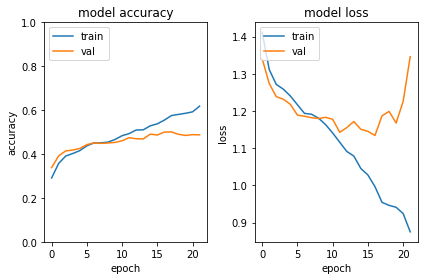

In [25]:
fig, axs = plt.subplots(1, 2)

axs[0].plot(hist.history["accuracy"])
axs[0].plot(hist.history["val_accuracy"])
axs[0].set_title("model accuracy")
axs[0].set_ylabel("accuracy")
axs[0].set_xlabel("epoch")
axs[0].set_ylim(0, 1)
axs[0].legend(["train", "val"], loc="upper left")

axs[1].plot(hist.history["loss"])
axs[1].plot(hist.history["val_loss"])
axs[1].set_title("model loss")
axs[1].set_ylabel("loss")
axs[1].set_xlabel("epoch")
# axs[1].set_ylim(0, 1)
axs[1].legend(["train", "val"], loc="upper left")

plt.tight_layout()
plt.show()
fig.savefig(os.path.join(p_dir, "accuracy_loss.jpg"))

# Sample images per category

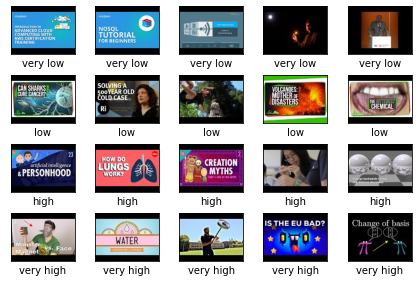

In [26]:
s = combo.loc[combo["id_video"].isin(x_train["id_video"]), ["id_video", "qtl"]].groupby("qtl", as_index=False).apply(lambda x: x.sample(5, random_state=15))

fig, axs = plt.subplots(len(cat_lbl), 5)
i = 0
for idx, row in s.iterrows():
    img = Image.open(os.path.join(img_dir, "{}.jpg".format(row["id_video"])))
    axs[i // 5, i % 5].imshow(img)
    axs[i // 5, i % 5].xaxis.set_ticklabels([])
    axs[i // 5, i % 5].xaxis.set_ticks([])
    axs[i // 5, i % 5].set_xlabel(row["qtl"])
    axs[i // 5, i % 5].yaxis.set_ticklabels([])
    axs[i // 5, i % 5].yaxis.set_ticks([])
    i += 1
plt.tight_layout()
plt.show()
fig.savefig(os.path.join(p_dir, "sample_images.jpg"))

# Confusion matrix

In [27]:
model.load_weights(os.path.join(p_dir, "{}".format(m_name)))

In [28]:
def test_generator(X, y, img_dir):
    combo = pd.concat([X, y], axis="columns")
    combo["file_name"] = combo.id_video + ".jpg"
    datagen = ImageDataGenerator()
    gen = datagen.flow_from_dataframe(dataframe=combo,
                                      directory=img_dir,
                                      x_col="file_name", 
                                      y_col="qtl",
                                      class_mode="categorical",
                                      color_mode="rgb",
                                      target_size=(120, 90),
                                      shuffle=False,
                                      batch_size=1                                      
                                     )
    return gen

In [29]:
img_dir = "../images"

x_test = pd.read_pickle(os.path.join(p_dir, "x_test.pkl"))
y_test = pd.read_pickle(os.path.join(p_dir, "y_test.pkl"))
test_gen = test_generator(x_test, y_test, img_dir)
y_pred = model.predict(test_gen, steps=y_test.shape[0])
y_pred = np.argmax(y_pred, axis=1)
cls_lbl = dict([(v, k) for k, v in test_gen.class_indices.items()])
y_pred = pd.Series([cls_lbl[i] for i in y_pred]).astype("category").cat.reorder_categories(cat_lbl)

Found 3863 validated image filenames belonging to 4 classes.


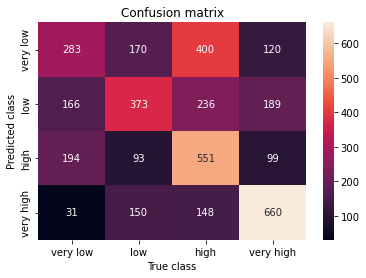

Accuracy: 0.48
Micro precision: 0.48
Micro recall: 0.48
Micro F1-score: 0.48
Macro precision: 0.48
Macro recall: 0.48
Macro F1-score: 0.47
Weighted precision: 0.48
Weighted recall: 0.48
Weighted F1-score: 0.47
              precision    recall  f1-score   support

    very low       0.42      0.29      0.34       973
         low       0.47      0.39      0.43       964
        high       0.41      0.59      0.49       937
   very high       0.62      0.67      0.64       989

    accuracy                           0.48      3863
   macro avg       0.48      0.48      0.47      3863
weighted avg       0.48      0.48      0.47      3863



In [30]:
cmtx = confusion_matrix(y_test, y_pred)
sb.heatmap(cmtx, annot=True, fmt="d", xticklabels=y_test.cat.categories, yticklabels=y_pred.cat.categories)
plt.xlabel("True class")
plt.ylabel("Predicted class")
plt.title("Confusion matrix")
plt.savefig(os.path.join(p_dir, "confusion_matrix.jpg"))
plt.show()

print("Accuracy: {:0.2f}".format(accuracy_score(y_test, y_pred)))

print("Micro precision: {:0.2f}".format(precision_score(y_test, y_pred, average="micro")))
print("Micro recall: {:0.2f}".format(recall_score(y_test, y_pred, average="micro")))
print("Micro F1-score: {:0.2f}".format(f1_score(y_test, y_pred, average="micro")))

print("Macro precision: {:0.2f}".format(precision_score(y_test, y_pred, average="macro")))
print("Macro recall: {:0.2f}".format(recall_score(y_test, y_pred, average="macro")))
print("Macro F1-score: {:0.2f}".format(f1_score(y_test, y_pred, average="macro")))

print("Weighted precision: {:0.2f}".format(precision_score(y_test, y_pred, average="weighted")))
print("Weighted recall: {:0.2f}".format(recall_score(y_test, y_pred, average="weighted")))
print("Weighted F1-score: {:0.2f}".format(f1_score(y_test, y_pred, average="weighted")))

print(classification_report(y_test, y_pred, target_names=cat_lbl))

# Grad-CAM class activation visualization

In [31]:
def get_img_array(img_path, size):
    img = load_img(img_path, target_size=size)
    array = img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def create_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = load_img(img_path)
    img = img_to_array(img)

    heatmap = np.uint8(255 * heatmap)

    jet = cm.get_cmap("jet")

    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = array_to_img(superimposed_img)

    return superimposed_img

In [32]:
def cam_image(img_dir, id_video, last_cl, alpha=0.4):
    img_path = os.path.join(img_dir, "{}.jpg".format(row["id_video"]))
    img_array = get_img_array(img_path, size=(120, 90))
    model.layers[-1].activation = None
    preds = model.predict(img_array)
    heatmap = make_gradcam_heatmap(img_array, model, last_cl)
    img = create_gradcam(img_path, heatmap, os.path.join(p_dir, "cam_{}.jpg".format(row["id_video"])), alpha)
    return img

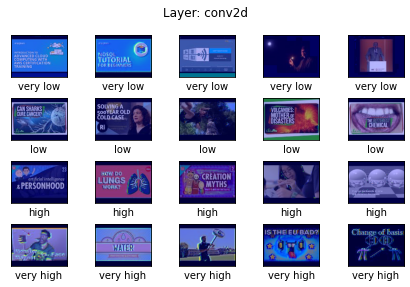

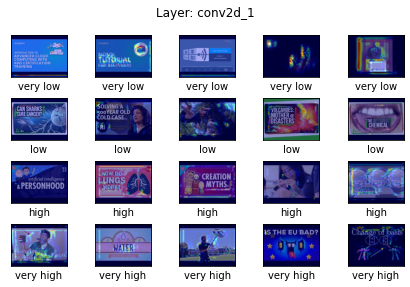

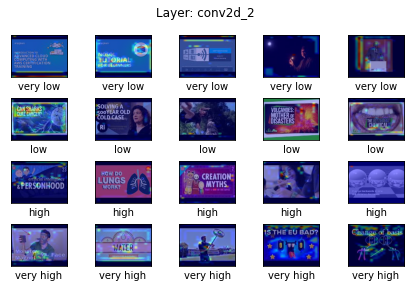

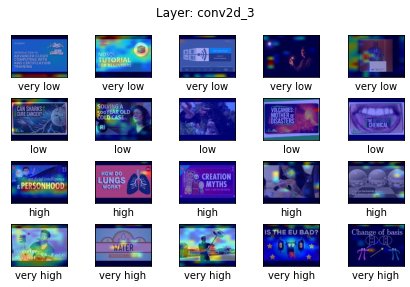

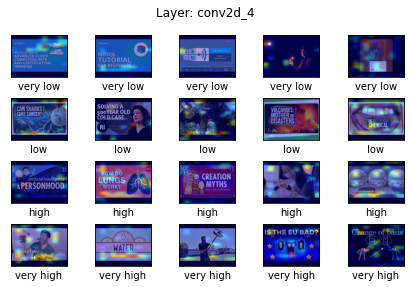

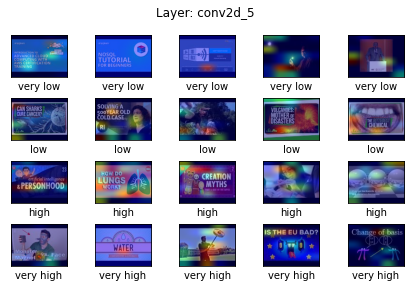

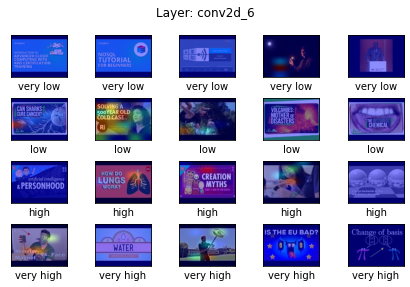

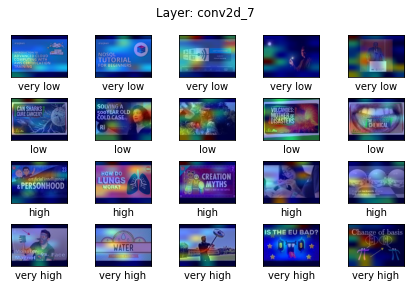

In [33]:
for layer in model.layers:
    if layer.name.startswith("conv"):        
        alpha = 0.8

        fig, axs = plt.subplots(len(cat_lbl), 5)
        i = 0
        for idx, row in s.iterrows():
            img_path = os.path.join(img_dir, "{}.jpg".format(row["id_video"]))
            img = cam_image(img_dir, row["id_video"], layer.name, alpha)
            axs[i // 5, i % 5].imshow(img)
            axs[i // 5, i % 5].xaxis.set_ticklabels([])
            axs[i // 5, i % 5].xaxis.set_ticks([])
            axs[i // 5, i % 5].set_xlabel(row["qtl"])
            axs[i // 5, i % 5].yaxis.set_ticklabels([])
            axs[i // 5, i % 5].yaxis.set_ticks([])
            i += 1
        plt.suptitle("Layer: {}".format(layer.name))
        plt.tight_layout()        
        plt.show()
        fig.savefig(os.path.join(p_dir, "cam_sample_{}.jpg".format(layer.name)))